# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [138]:
%pip install wordcloud
%pip install xgboost
%pip install keras==2.15.0

%pip install transformers torch
%pip install --upgrade tensorflow transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
Note: you may need to restart the kernel to use updated packages.


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stapa1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [140]:
#Load the data

data = pd.read_csv(r"Data/amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (4785, 5)


In [141]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [142]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [143]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [144]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [145]:
#We will drop the null record

data.dropna(inplace=True)

In [146]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (4784, 5)


In [147]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [148]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [149]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [150]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [151]:
len(data)

4784

In [152]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
1    1796
4     455
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

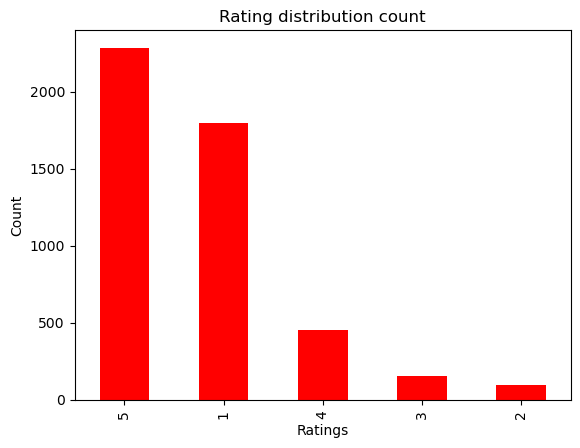

In [153]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [154]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    47.78
1    37.54
4     9.51
3     3.18
2     1.99
Name: count, dtype: float64


Let's plot the above values in a pie chart

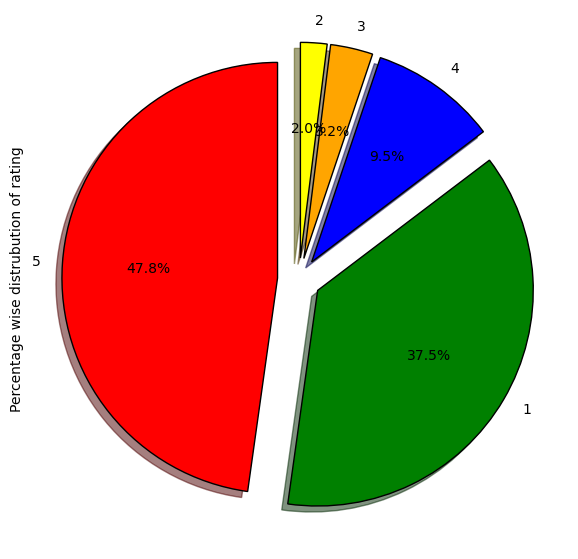

In [155]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [156]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0    1891
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [157]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [158]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

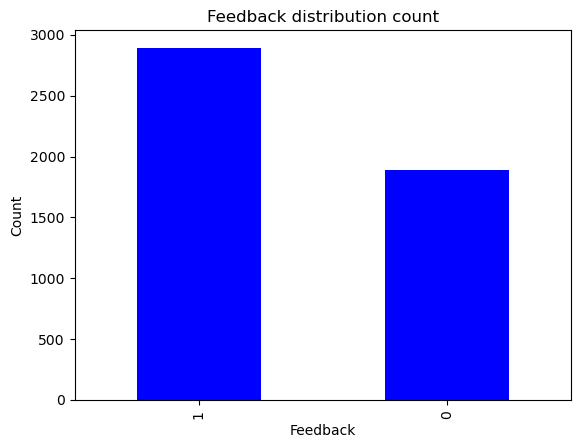

In [159]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [160]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    60.47
0    39.53
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

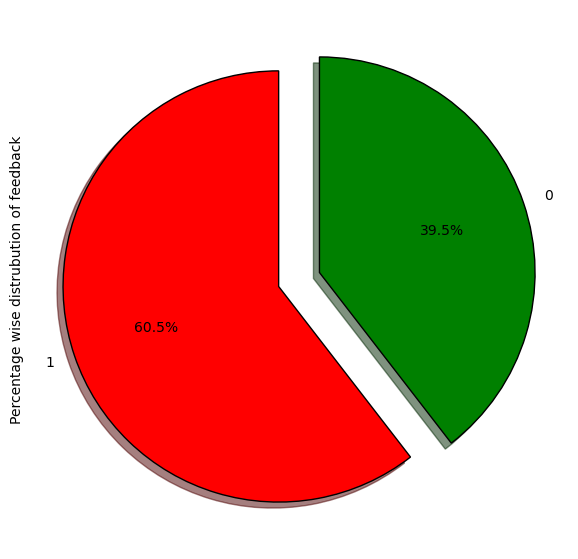

In [161]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [162]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    1796
2      95
Name: count, dtype: int64

In [163]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [164]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      2151
Charcoal Fabric                  430
Configuration: Fire TV Stick     350
Black  Plus                      270
Black  Show                      265
Black                            261
Black  Spot                      241
White  Dot                       184
Heather Gray Fabric              157
White  Spot                      109
Sandstone Fabric                  90
White                             90
White  Show                       85
White  Plus                       78
Oak Finish                        14
Walnut Finish                      9
Name: count, dtype: int64


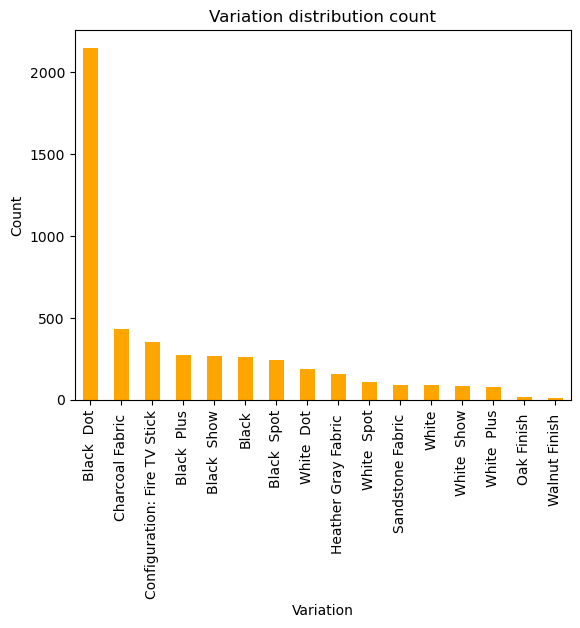

In [165]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [166]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      44.96
Charcoal Fabric                  8.99
Configuration: Fire TV Stick     7.32
Black  Plus                      5.64
Black  Show                      5.54
Black                            5.46
Black  Spot                      5.04
White  Dot                       3.85
Heather Gray Fabric              3.28
White  Spot                      2.28
Sandstone Fabric                 1.88
White                            1.88
White  Show                      1.78
White  Plus                      1.63
Oak Finish                       0.29
Walnut Finish                    0.19
Name: count, dtype: float64


Mean rating according to variation

In [167]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      1.828452
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

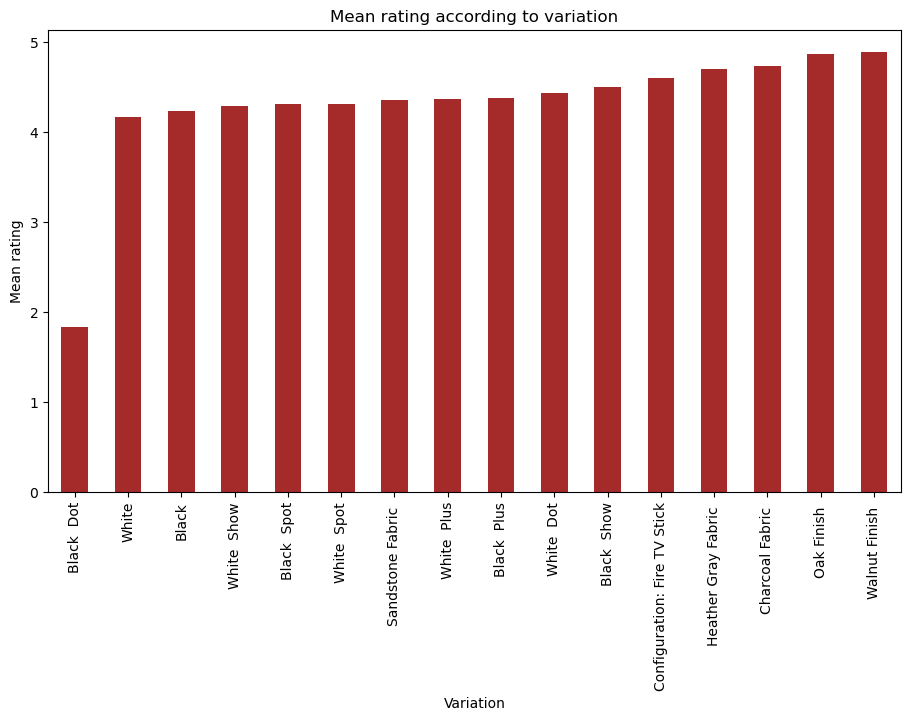

In [168]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [169]:
data['length'].describe()

count    4784.000000
mean      107.423913
std       153.757028
min         1.000000
25%        24.000000
50%        73.000000
75%       114.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

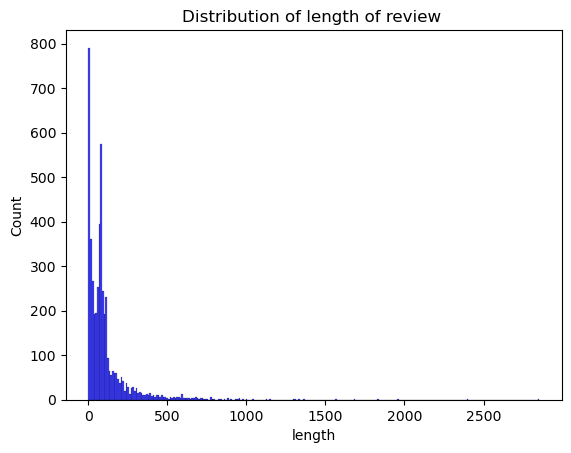

In [170]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

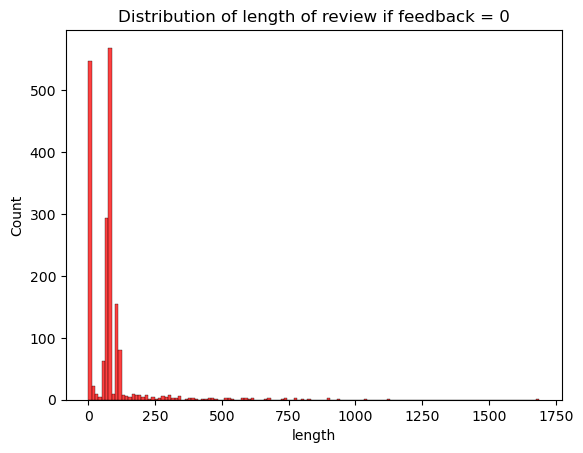

In [171]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

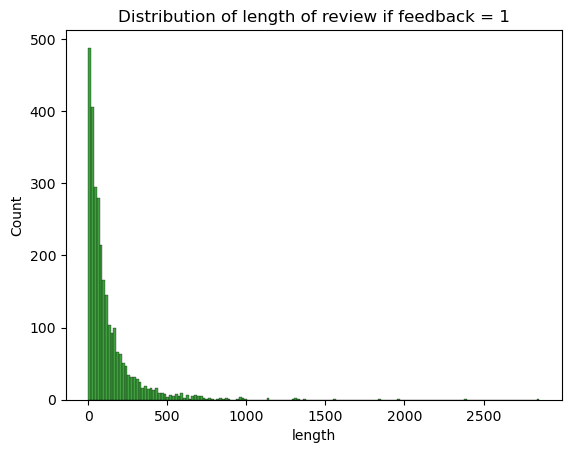

In [172]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

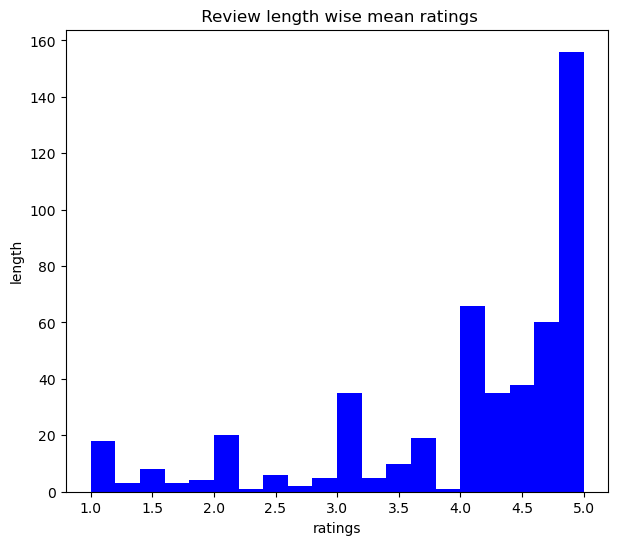

In [173]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [174]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

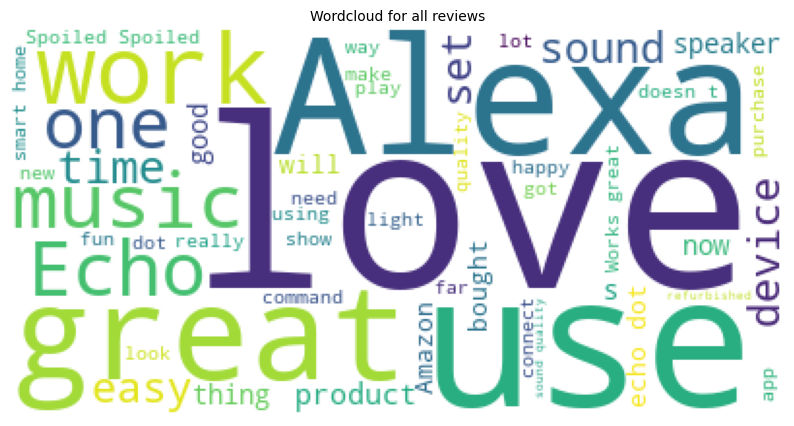

In [175]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [176]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


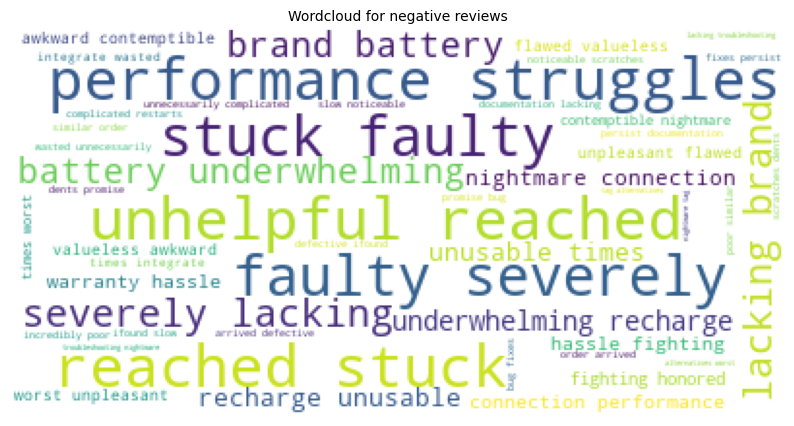

In [177]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

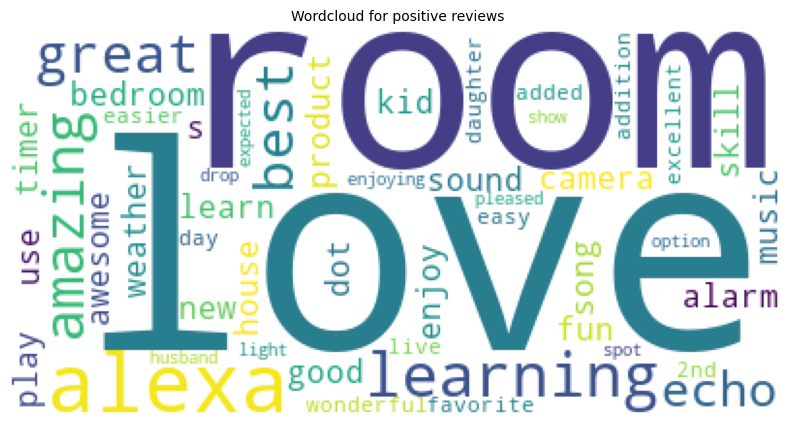

In [178]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [179]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [180]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [181]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [182]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (4784, 2500)
y shape: (4784,)


Splitting data into train and test set with 30% data with testing.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (3348, 2500)
y train: (3348,)
X test: (1436, 2500)
y test: (1436,)


In [184]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 9


We'll scale X_train and X_test so that all values are between 0 and 1.

In [185]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [186]:
pip install imbalanced-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [187]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from imblearn.over_sampling import SMOTE  # Import SMOTE here


# # Handle class imbalance using SMOTE on the scaled training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Check the distribution of classes after resampling
# print("Original training set shape:", X_train.shape, y_train.value_counts())
# print("Resampled training set shape:", X_train_resampled.shape, y_train_resampled.value_counts())

In [188]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
import pickle

# Assume 'data' is already defined and contains the dataset with 'verified_reviews' and 'feedback' columns

# Preprocessing
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

cv = CountVectorizer(max_features=2500)

# Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

# Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

# Scale X_train and X_test so that all values are between 0 and 1
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# Handle class imbalance using SMOTE on the scaled training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scl, y_train)  # Use X_train_scl here

# Check the distribution of classes after resampling
print("Original training set shape:", X_train.shape, pd.Series(y_train).value_counts())  # Convert to Series for value_counts
print("Resampled training set shape:", X_train_resampled.shape, pd.Series(y_train_resampled).value_counts())  # Convert to Series

X shape: (4784, 2500)
y shape: (4784,)
X train: (3348, 2500)
y train: (3348,)
X test: (1436, 2500)
y test: (1436,)
X train max value: 12
X test max value: 9
Original training set shape: (3348, 2500) 1    2065
0    1283
Name: count, dtype: int64
Resampled training set shape: (4130, 2500) 0    2065
1    2065
Name: count, dtype: int64


In [189]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

#### Random Forest

In [190]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [191]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9961170848267622
Testing Accuracy : 0.9568245125348189


In [192]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [193]:
# y_preds1 = model_rf.predict(X_train_scl)
# #Confusion Matrix

# cm1 = confusion_matrix(y_train, y_preds1)

In [194]:
# cm_display1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=model_rf.classes_)
# cm_display1.plot()
# plt.show()

In [195]:
# 117/(117+61)

In [196]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[547,  61],
       [  1, 827]])

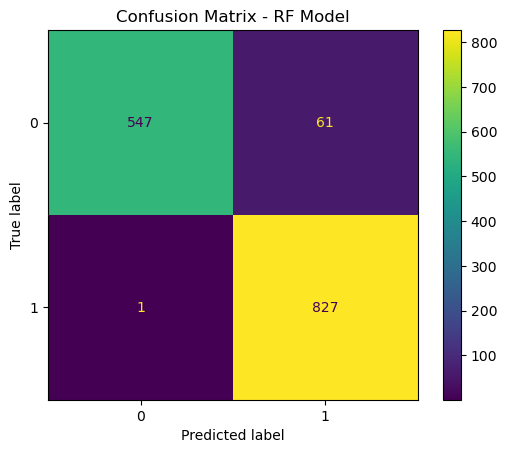

In [197]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.title("Confusion Matrix - RF Model")
plt.show()

K fold cross-validation

In [198]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9534069175082671
Standard Variance : 0.006418881148946852


Applying grid search to get the optimal parameters on random forest

In [199]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [200]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [201]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [202]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 98.95459976105138
Cross validation mean accuracy on test set : 95.07541816009558
Accuracy score for test set : 0.9568245125348189


In [203]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scl)

In [204]:
print("Training Accuracy :", best_model.score(X_train_scl, y_train))
print("Testing Accuracy :", best_model.score(X_test_scl, y_test))

Training Accuracy : 0.9895459976105138
Testing Accuracy : 0.9533426183844012


In [205]:
#Confusion Matrix
cm3 = confusion_matrix(y_test, y_pred)

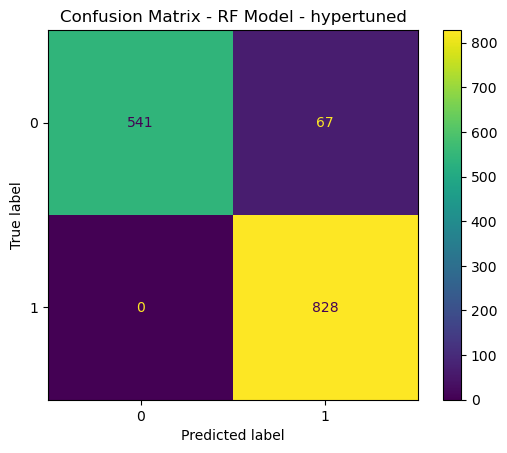

In [206]:
cm_display3 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=model_rf.classes_)
cm_display3.plot()
plt.title("Confusion Matrix - RF Model - hypertuned")
plt.show()

In [207]:
pickle.dump(best_model, open('Models/tuned_rf_model.pkl', 'wb'))

#### XgBoost

In [208]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [209]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9775985663082437
Testing Accuracy : 0.958217270194986


In [210]:
y_preds = model_xgb.predict(X_test)

In [211]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[565  43]
 [ 14 814]]


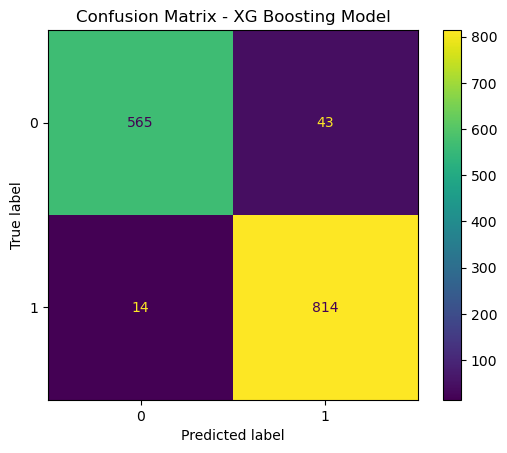

In [212]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.title("Confusion Matrix - XG Boosting Model")
plt.show()

In [213]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [214]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [215]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9961170848267622
Testing Accuracy : 0.9428969359331476


In [216]:
y_preds = model_dt.predict(X_test)

In [217]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[549  59]
 [ 52 776]]


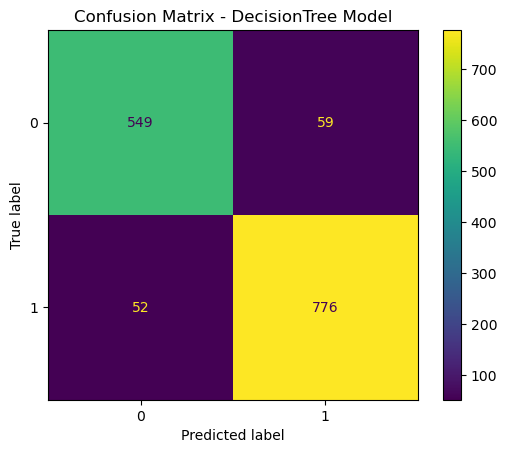

In [218]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.title("Confusion Matrix - DecisionTree Model")
plt.show()

In [219]:
pickle.dump(model_dt, open('Models/model_dt.pkl', 'wb'))

#### Ensemble model

Ensemble Model Training Accuracy: 0.9958183990442055
Ensemble Model Testing Accuracy: 0.9568245125348189


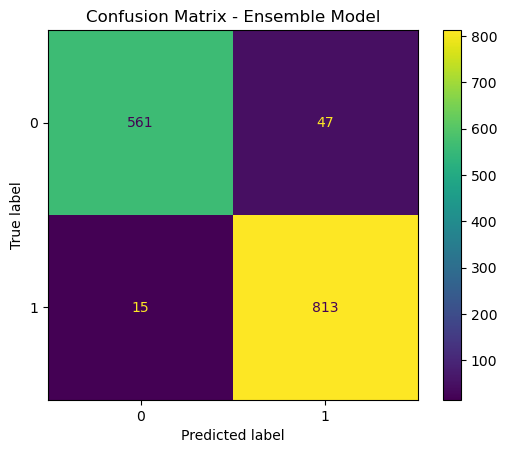

In [220]:
from sklearn.ensemble import VotingClassifier

# Initialize your individual models, assuming they have already been trained
model_rf = RandomForestClassifier(**grid_search.best_params_)  # Use best parameters from your grid search
model_xgb = XGBClassifier()  # Ensure you have already trained it
model_dt = DecisionTreeClassifier()

# Fit the models on training data
model_rf.fit(X_train_scl, y_train)
model_xgb.fit(X_train_scl, y_train)
model_dt.fit(X_train_scl, y_train)

# Create the Voting Classifier with soft voting
voting_model = VotingClassifier(estimators=[
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('dt', model_dt)], voting='soft')

# Train the ensemble model
voting_model.fit(X_train_scl, y_train)

# Evaluate the ensemble model
train_accuracy = voting_model.score(X_train_scl, y_train)
test_accuracy = voting_model.score(X_test_scl, y_test)

print("Ensemble Model Training Accuracy:", train_accuracy)
print("Ensemble Model Testing Accuracy:", test_accuracy)

# Make predictions on the test set
y_preds_ensemble = voting_model.predict(X_test_scl)

# Confusion Matrix for the ensemble model
cm = confusion_matrix(y_test, y_preds_ensemble)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_model.classes_)
cm_display.plot()
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

# Save the ensemble model for future use
pickle.dump(voting_model, open('Models/voting_model.pkl', 'wb'))

# Function to predict sentiment of new text
def predict_sentiment(text):
    # Load the CountVectorizer and MinMaxScaler
    cv_loaded = pickle.load(open('Models/countVectorizer.pkl', 'rb'))
    scaler_loaded = pickle.load(open('Models/scaler.pkl', 'rb'))
    
    # Preprocessing the text
    review = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]  # Stem and remove stopwords
    review = ' '.join(review)

    # Vectorize the text
    review_vectorized = cv_loaded.transform([review]).toarray()
    
    # Scale the features
    review_scaled = scaler_loaded.transform(review_vectorized)

    # Make prediction
    prediction = voting_model.predict(review_scaled)
    return 'Positive' if prediction[0] == 1 else 'Negative'


#### Prediction with ensemble model

In [221]:
# Example usage:
new_review = "I absolutely love this product! It works perfectly."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


In [222]:
new_review = "The device stopped working within a week of purchase"
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


In [223]:
new_review = "The sound quality is terrible; it's too muffled to enjoy."

predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative


In [224]:
new_review = "Initially, this echo dot worked very well. Over time, the dot stopped responding to 'alexa' unless you were within one foot of it yelling"
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


In [225]:

new_review = "This is the worst Amazon purchase I have made. I am big Amazon fan...love the brand...unlimited digital music...prime videos...even buy my online games, music, and movies through Amazon. This app I have tried to use it make simple purchases -- to do anything. It is useless."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative


In [226]:


new_review = "This product was supposed to work with my existing systems, but it just doesn't connect properly."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative


In [227]:
new_review = "The quality of the microphone is terrible; it picks up background noise but not my voice."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative


In [228]:
new_review= "I was really excited to try this out, but it failed to meet any of my expectations."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative


In [229]:
new_review="The quality of the microphone is terrible; it picks up background noise but not my voice."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative


In [230]:
new_review="It's unreliable and doesn't perform consistently. Some days it works fine, and other days it's a hassle."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


In [231]:
# Extracted more negative sentences
negative_sentences = data[data['feedback'] == 0]['verified_reviews']

# Convert to list
negative_sentences_list = negative_sentences.tolist()

# Print even more negative sentences
for sentence in negative_sentences_list[20:40]:  # Adjust this range for more sentences
    print(sentence)

"Initially, this echo dot worked very well. Over time, the dot stopped responding to 'alexa' unless you were within one foot of it yelling. The other echos/echo dots in other rooms would respond without a response from this echo dot. Would not recommend buying refurbished."
"I bought an echo dot that had been refurbished but its stops whatever function its performing quite often, doesn't wake up every time, randomly turns on but does nothing. Do not buy a refurbished Echo dot."
Dont trust this....
 
I wanted to use these as a radio and intercom as we get terrible fm reception where i live.  The speech recognition software is horrible.  My wife and i both are native Americans whose language is English she is from the north i am from Texas  neither have an accent from our birth area and yet it does not do a good job understanding us.  We bought two they do the same thing.  Additionally wifi reception was poor to marginal. I had to buy Wifi range extender for office and the other is ten f

#### Bert model

In [232]:
from transformers import pipeline

# Load the BERT sentiment analysis model using CPU
sentiment_pipeline = pipeline("sentiment-analysis", 
                               model="nlptown/bert-base-multilingual-uncased-sentiment", 
                               device=-1)  # Use CPU

# Predicting sentiment
new_review = "Now I'm weary about these picking up conversations when you are not actively using them - heard about this happening on the news."
result = sentiment_pipeline(new_review)

print(result)  # Output sentiment analysis result

[{'label': '2 stars', 'score': 0.32234904170036316}]


/opt/homebrew/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [233]:


# Predicting sentiment
new_review = "This is the worst Amazon purchase I have made. I am big Amazon fan...love the brand...unlimited digital music...prime videos...even buy my online games, music, and movies through Amazon. This app I have tried to use it make simple purchases -- to do anything. It is useless."
result = sentiment_pipeline(new_review)

# Interpret the result to classify as Positive or Negative
# The labels are in the format '1 star' to '5 stars'
label = result[0]['label']
score = result[0]['score']

if "1 star" in label or "2 stars" in label:
    sentiment = "Negative"
else:
    sentiment = "Positive"

print(f"Predicted Sentiment: {sentiment} (Score: {score:.2f})")

Predicted Sentiment: Negative (Score: 0.96)


In [234]:
from transformers import pipeline

# Load the sentiment analysis model using CPU
sentiment_pipeline = pipeline("sentiment-analysis", 
                               model="nlptown/bert-base-multilingual-uncased-sentiment", 
                               device=-1)  # Use CPU

# Sample test dataset (text, actual sentiment)
# Here, we categorize stars as "POSITIVE" if it's 3 stars or above, and "NEGATIVE" if it's 1 or 2 stars
test_data = [
    ("I love this product!", "POSITIVE"),                # Expects high rating
    ("This is the worst experience I've ever had.", "NEGATIVE"),  # Expects low rating
    ("It's okay, not great, but not terrible.", "NEGATIVE"),  # Expects low rating
    ("Absolutely fantastic! Highly recommend.", "POSITIVE"),  # Expects high rating
    ("I'm very disappointed in the quality.", "NEGATIVE"),   # Expects low rating
]

# Initialize variables for accuracy calculation
correct_predictions = 0

# Make predictions and compare with actual labels
for text, true_label in test_data:
    result = sentiment_pipeline(text)
    label = result[0]['label']
    
    # Determine sentiment based on the star rating
    if "1 star" in label or "2 stars" in label:
        predicted_label = "NEGATIVE"
    else:
        predicted_label = "POSITIVE"

    # Compare predicted label with the true label
    if predicted_label == true_label:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / len(test_data) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 80.00%


#### Fine-Tuning Bert model

In [235]:
pip install transformers torch scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [236]:
pip install transformers[torch] accelerate --upgrade

zsh:1: no matches found: transformers[torch]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [237]:
!pip install transformers[torch]
!pip install accelerate --upgrade

zsh:1: no matches found: transformers[torch]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [238]:
!pip show transformers
!pip show accelerate
!pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: transformers
Version: 4.44.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/homebrew/anaconda3/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: accelerate
Version: 0.33.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /opt/homebrew/anaconda3/lib/python3.12/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [239]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch

# Assume ratings are in the range of 1-5 (1 = negative sentiment, 5 = positive sentiment)
X = data['verified_reviews']  # or data['feedback'] depending on your preference
y = data['rating']  # Assuming rating is the target variable

# Convert ratings to binary sentiment (1 = positive, 0 = negative)
y = (y > 3).astype(int)  # Simple binary classification: 1 if rating > 3, else 0.

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [240]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Tokenize the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')


/opt/homebrew/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [241]:
# Define a custom PyTorch dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
# Create dataset objects
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())

In [242]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Loading the model with the correct number of labels
model = BertForSequenceClassification.from_pretrained(
    'nlptown/bert-base-multilingual-uncased-sentiment',
    num_labels=5,
    ignore_mismatched_sizes=True
)

# Definingtraining arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Define `train_dataset` and `eval_dataset` as per your data preparation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()



  0%|          | 0/1437 [00:00<?, ?it/s]

{'loss': 3.34, 'grad_norm': 42.34137725830078, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'loss': 2.9426, 'grad_norm': 29.578815460205078, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'loss': 2.097, 'grad_norm': 32.0611572265625, 'learning_rate': 3e-06, 'epoch': 0.06}
{'loss': 1.3815, 'grad_norm': 9.618882179260254, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}
{'loss': 1.0353, 'grad_norm': 11.297602653503418, 'learning_rate': 5e-06, 'epoch': 0.1}
{'loss': 0.7005, 'grad_norm': 6.256375789642334, 'learning_rate': 6e-06, 'epoch': 0.13}
{'loss': 0.4927, 'grad_norm': 6.0662312507629395, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.15}
{'loss': 0.3279, 'grad_norm': 5.337822914123535, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.17}
{'loss': 0.2623, 'grad_norm': 7.884115695953369, 'learning_rate': 9e-06, 'epoch': 0.19}
{'loss': 0.2521, 'grad_norm': 0.4766777753829956, 'learning_rate': 1e-05, 'epoch': 0.21}
{'loss': 0.1988, 'grad_norm': 8.6912069

TrainOutput(global_step=1437, training_loss=0.2126774382414575, metrics={'train_runtime': 2538.6182, 'train_samples_per_second': 4.523, 'train_steps_per_second': 0.566, 'total_flos': 3020859393629184.0, 'train_loss': 0.2126774382414575, 'epoch': 3.0})

In [243]:
eval_results = trainer.evaluate()
print(eval_results)  # Check available keys and their values

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.17009977996349335, 'eval_runtime': 37.6847, 'eval_samples_per_second': 25.395, 'eval_steps_per_second': 3.184, 'epoch': 3.0}


In [244]:
from sklearn.metrics import accuracy_score

# Use the Trainer to make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions  # Get the logits
labels = predictions.label_ids  # Get the true labels

# Calculate accuracy
predicted_classes = torch.argmax(torch.tensor(logits), dim=1)
accuracy = accuracy_score(labels, predicted_classes)



  0%|          | 0/120 [00:00<?, ?it/s]

In [245]:
# Print the accuracy as a percentage
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.66%


In [246]:
# Save the model and tokenizer
model.save_pretrained('./bert_model')
tokenizer.save_pretrained('./bert_model')

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


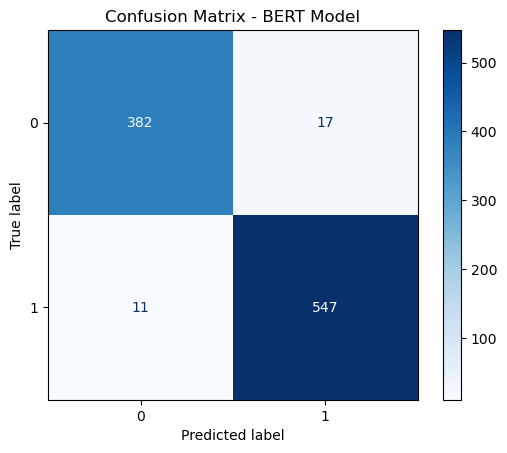

              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96       399
    Positive       0.97      0.98      0.98       558

    accuracy                           0.97       957
   macro avg       0.97      0.97      0.97       957
weighted avg       0.97      0.97      0.97       957



In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract the predicted classes as before
predicted_classes = torch.argmax(torch.tensor(logits), dim=1)

# Compute confusion matrix
cm = confusion_matrix(labels, predicted_classes)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Assuming binary classification (0 for negative, 1 for positive)
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix - BERT Model")
plt.show()

# Optional: Print classification report
from sklearn.metrics import classification_report
print(classification_report(labels, predicted_classes, target_names=['Negative', 'Positive']))

In [247]:
# import os
# import pickle

# # Define the directory where you want to save the model
# model_dir = 'Models/bert_fine_tunned_model'

# # Create the directory if it doesn't exist
# os.makedirs(model_dir, exist_ok=True)

# # Assuming your model is trained and named as `model`
# with open(os.path.join(model_dir, 'bert_fine_tunned_model.pkl'), 'wb') as f:
#     pickle.dump(model.state_dict(), f)

# print(f"Model saved as '{os.path.join(model_dir, 'bert_fine_tunned_model.pkl')}'.")

Model saved as 'Models/bert_fine_tunned_model/bert_fine_tunned_model.pkl'.


## Conclusion
Choosing BERT for sentiment analysis of product reviews is supported by its superior performance, advanced contextual understanding, and capabilities in handling complex language nuances. The achieved accuracy of **97%** demonstrates its effectiveness in extracting valuable information from consumer reviews, making it an essential tool for businesses looking to enhance their understanding of customer sentiment. Although ensemble models also offer good accuracy, BERT's robustness and context-grasping ability provide significant advantages in this application.